A time series is a series of data points indexed in time order. Most commonly, a time series is a sequence taken at successive equally spaced points in time. Thus it is a sequence of discrete-time data.

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
# Dataset is weather time series dataset recorded by the Max Planck Institute for Biogeochemistry.
# The dataset contains 14 different features such as air temperature, atmospheric pressure, 
# and humidity. These were collected every 10 minutes, beginning in 2003. We will use data 
# collected between 2009 and 2016. 

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13582336/13568290 [==============================] - 0s 0us/step


In [3]:
df = pd.read_csv(csv_path)
df.head(10)

# p (mbar) -> Atmospheric pressure in millibars
# T (degC) -> Temperature in Celsius
# Tpot (K) -> Temperature in Kelvin
# Tdew (degC) -> Temperature in Celsius relative to humidity.
# rh (%) -> Relative Humidity
# VPmax (mbar) -> Saturation vapor pressure
# VPact (mbar) -> Vapor pressure
# VPdef (mbar) -> Vapor pressure deficit
# sh (g/kg) -> Specific humidity
# H2OC (mmol/mol) -> Water vapor concentration
# rho (g/m**3) -> Airtight
# wv (m/s) -> Wind speed
# max. wv (m/s) -> Maximum wind speed
# wd (deg) -> Wind direction in degrees

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


In [4]:
# We are going to deal with hourly predictions, so start by sub-sampling the data 
# from 10-minute intervals to one-hour intervals

df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


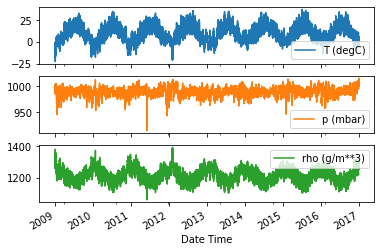

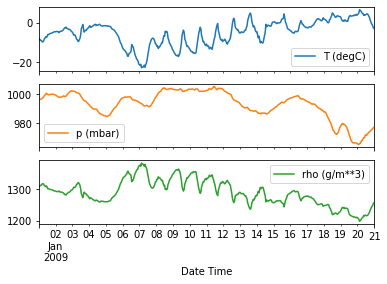

In [6]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [8]:
# min value of the wind velocity (wv (m/s)) and the maximum value (max. wv (m/s)) columns
# is -9999. It is likely erroneous.
# There's a separate wind direction column, so the velocity should be greater than zero (>=0). 
# Replace it with zeros

wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

Text(0, 0.5, 'Wind Velocity [m/s]')

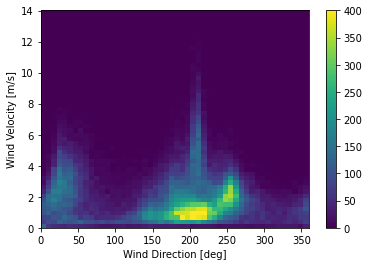

In [9]:
# Before diving in to build a model, it's important to understand your data and be sure that 
# you're passing the model appropriately formatted data.

# The last column of the data, wd (deg)—gives the wind direction in units of degrees. 
# Angles do not make good model inputs: 360° and 0° should be close to each other and wrap 
# around smoothly. Direction shouldn't matter if the wind is not blowing.

plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [10]:
# Convert the wind direction and velocity columns to a wind vector for better interpretation

wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

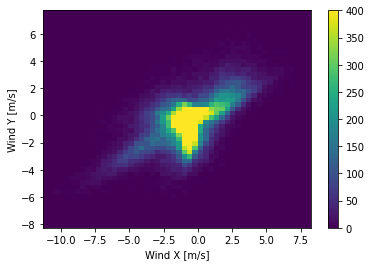

In [11]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [12]:
dt = date_time.tolist()
print(dt[0:10])
print(type(dt[0]))

[Timestamp('2009-01-01 01:00:00'), Timestamp('2009-01-01 02:00:00'), Timestamp('2009-01-01 03:00:00'), Timestamp('2009-01-01 04:00:00'), Timestamp('2009-01-01 05:00:00'), Timestamp('2009-01-01 06:00:00'), Timestamp('2009-01-01 07:00:00'), Timestamp('2009-01-01 08:00:00'), Timestamp('2009-01-01 09:00:00'), Timestamp('2009-01-01 10:00:00')]
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [13]:
# Convert date and time to seconds

timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s

5         1.230772e+09
11        1.230775e+09
17        1.230779e+09
23        1.230782e+09
29        1.230786e+09
              ...     
420521    1.483211e+09
420527    1.483215e+09
420533    1.483219e+09
420539    1.483222e+09
420545    1.483226e+09
Name: Date Time, Length: 70091, dtype: float64

In [14]:
# Similar to the wind direction, the time in seconds is not a useful model input. 
# Being weather data, it has daily and yearly periodicity. 
# There are many ways you could deal with periodicity.
# You can get usable signals by using sine and cosine transforms to clear "Time of day" and 
# "Time of year" signals

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

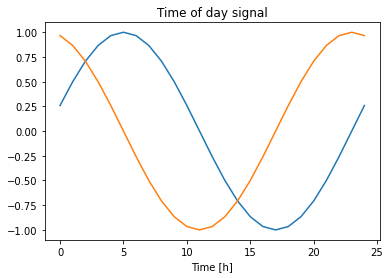

In [15]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

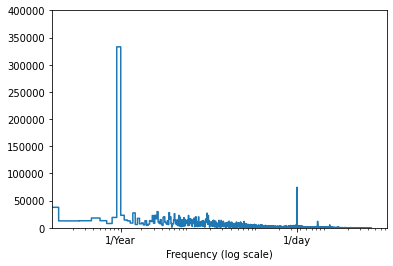

In [16]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [17]:
# Use a (70%, 20%, 10%) split for the training, validation, and test sets. 
# Here, the data is not being randomly shuffled before splitting. 
# This is for two reasons:
# a) It ensures that chopping the data into windows of consecutive samples is still possible.
# b) It ensures that the validation/test results are more realistic, being evaluated on the 
#    data collected after the model was trained.

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [18]:
# Normalize the data

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

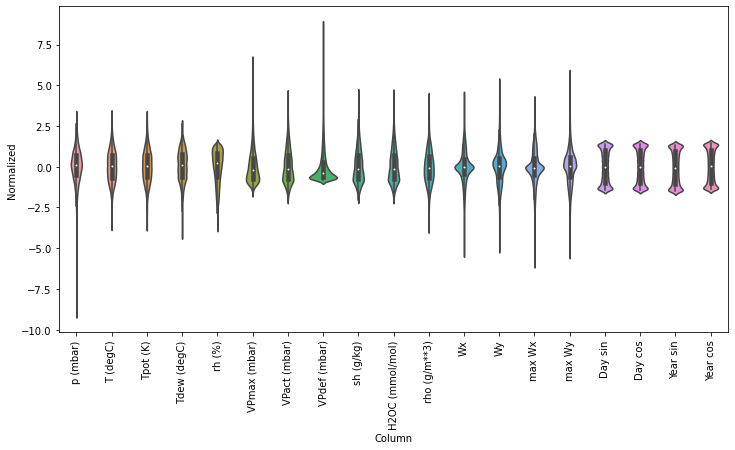

In [19]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [20]:
# Data windowing
# The main features of the input windows are: 
#   a) The width (number of time steps) of the input and label windows.'
#   b) The time offset between them.
#   c) Which features are used as inputs, labels, or both.
# Use the windowing approach for 
#   a) Single-output, and multi-output predictions.
#   b) Single-time-step and multi-time-step predictions.

In [21]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [22]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [23]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [24]:
# Given a list of consecutive inputs, the split_window method will convert them to 
# a window of inputs and a window of labels.
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [25]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


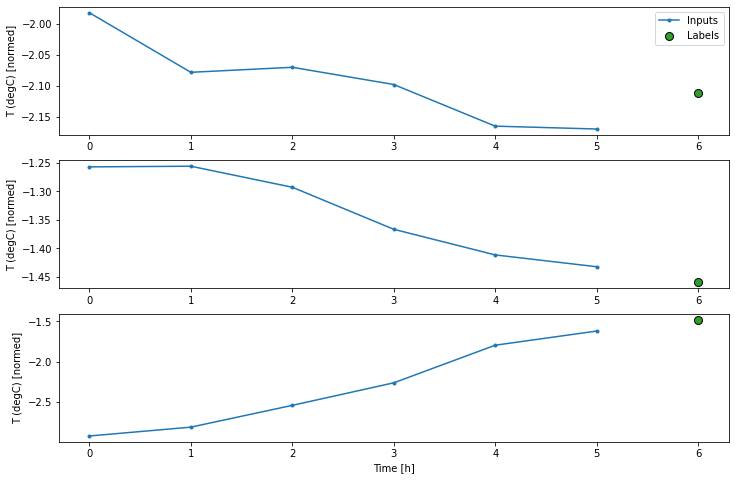

In [26]:
w2.example = example_inputs, example_labels

def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

w2.plot()

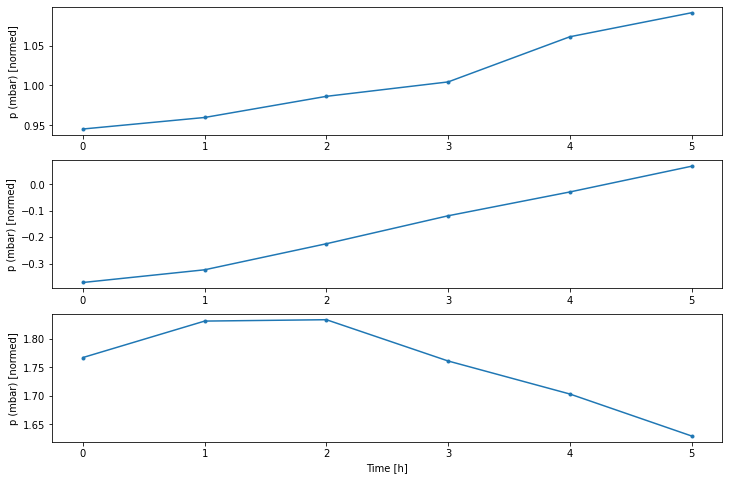

In [27]:
w2.plot(plot_col='p (mbar)')

In [28]:
# Finally, this make_dataset method will take a time series DataFrame and convert it to 
# a tf.data.Dataset of (input_window, label_window) pairs using the 
# tf.keras.utils.timeseries_dataset_from_array function

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [29]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [30]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [31]:
# Iterating over a Dataset yields concrete batches

for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [32]:
# Single step models
# Predicts a single feature's value—1 time step (one hour) into the future based only 
# on the current conditions.

# Configure a WindowGenerator object to produce these single-step (input, label) pairs:

single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [33]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [34]:
# To make the time axis acts like the batch axis: 
# each prediction is made independently with no interaction between time steps:

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [35]:
print('Input shape:', wide_window.example[0].shape)

Input shape: (32, 24, 19)


In [36]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [37]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [38]:
history = compile_and_fit(linear, single_step_window)

print(linear.evaluate(single_step_window.val))
print(linear.evaluate(single_step_window.test, verbose=0))

Epoch 1/100
1534/1534 [==============================] - 10s 6ms/step - loss: 0.1215 - mean_absolute_error: 0.2144 - val_loss: 0.0145 - val_mean_absolute_error: 0.0880
Epoch 2/100
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0112 - mean_absolute_error: 0.0776 - val_loss: 0.0093 - val_mean_absolute_error: 0.0710
Epoch 3/100
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0095 - mean_absolute_error: 0.0716 - val_loss: 0.0090 - val_mean_absolute_error: 0.0699
Epoch 4/100
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0093 - mean_absolute_error: 0.0705 - val_loss: 0.0088 - val_mean_absolute_error: 0.0688
Epoch 5/100
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0092 - mean_absolute_error: 0.0701 - val_loss: 0.0088 - val_mean_absolute_error: 0.0690
Epoch 6/100
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0091 - mean_absolute_error: 0.0699 - val_loss: 0.0088 - val_mean_absolute_error: 0.06

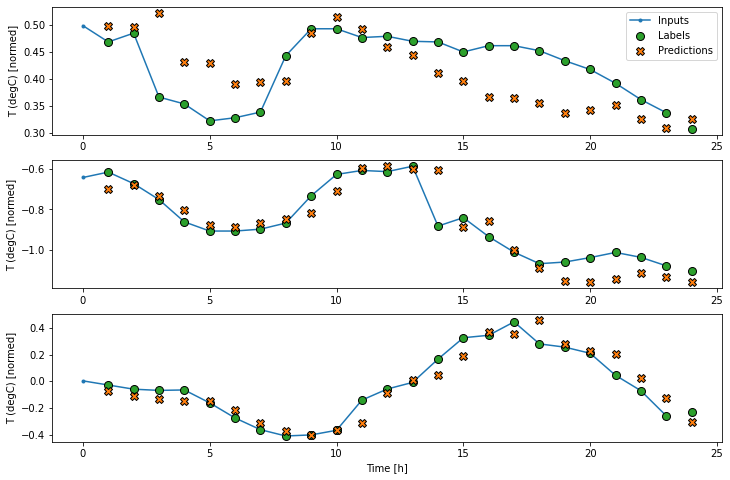

In [39]:
wide_window.plot(linear)

In [40]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

Epoch 1/100
1534/1534 [==============================] - 12s 7ms/step - loss: 0.0160 - mean_absolute_error: 0.0789 - val_loss: 0.0086 - val_mean_absolute_error: 0.0693
Epoch 2/100
1534/1534 [==============================] - 12s 8ms/step - loss: 0.0078 - mean_absolute_error: 0.0639 - val_loss: 0.0087 - val_mean_absolute_error: 0.0682
Epoch 3/100
1534/1534 [==============================] - 10s 7ms/step - loss: 0.0074 - mean_absolute_error: 0.0619 - val_loss: 0.0076 - val_mean_absolute_error: 0.0641
Epoch 4/100
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0072 - mean_absolute_error: 0.0609 - val_loss: 0.0073 - val_mean_absolute_error: 0.0612
Epoch 5/100
1534/1534 [==============================] - 10s 7ms/step - loss: 0.0070 - mean_absolute_error: 0.0599 - val_loss: 0.0072 - val_mean_absolute_error: 0.0613
Epoch 6/100
1534/1534 [==============================] - 10s 7ms/step - loss: 0.0069 - mean_absolute_error: 0.0590 - val_loss: 0.0072 - val_mean_absolute_error:

In [41]:
print(dense.evaluate(single_step_window.test, verbose=0))

[0.006580790970474482, 0.058152660727500916]


In [42]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

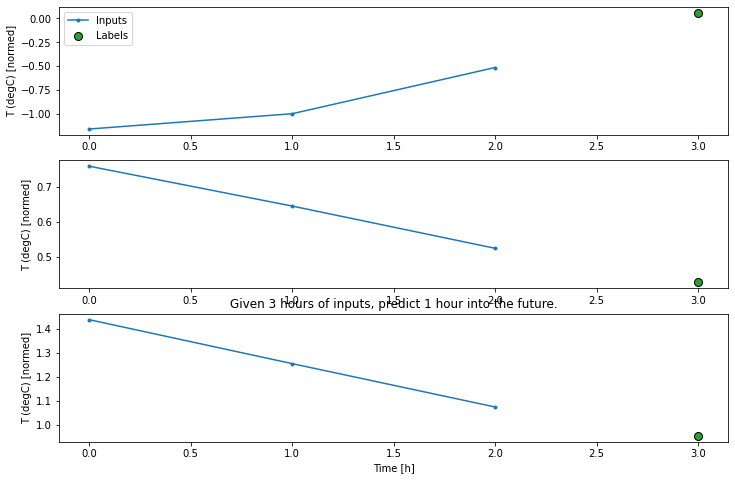

In [43]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [44]:
dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [45]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [46]:
history = compile_and_fit(dense, conv_window)

Epoch 1/100
1534/1534 [==============================] - 9s 5ms/step - loss: 0.0217 - mean_absolute_error: 0.0995 - val_loss: 0.0086 - val_mean_absolute_error: 0.0678
Epoch 2/100
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0085 - mean_absolute_error: 0.0669 - val_loss: 0.0074 - val_mean_absolute_error: 0.0622
Epoch 3/100
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0076 - mean_absolute_error: 0.0627 - val_loss: 0.0071 - val_mean_absolute_error: 0.0612
Epoch 4/100
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0073 - mean_absolute_error: 0.0611 - val_loss: 0.0068 - val_mean_absolute_error: 0.0597
Epoch 5/100
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0071 - mean_absolute_error: 0.0598 - val_loss: 0.0067 - val_mean_absolute_error: 0.0595
Epoch 6/100
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0069 - mean_absolute_error: 0.0591 - val_loss: 0.0083 - val_mean_absolute_error: 0.066

In [47]:
dense.evaluate(conv_window.test, verbose=0)

[0.006169479340314865, 0.05633709952235222]

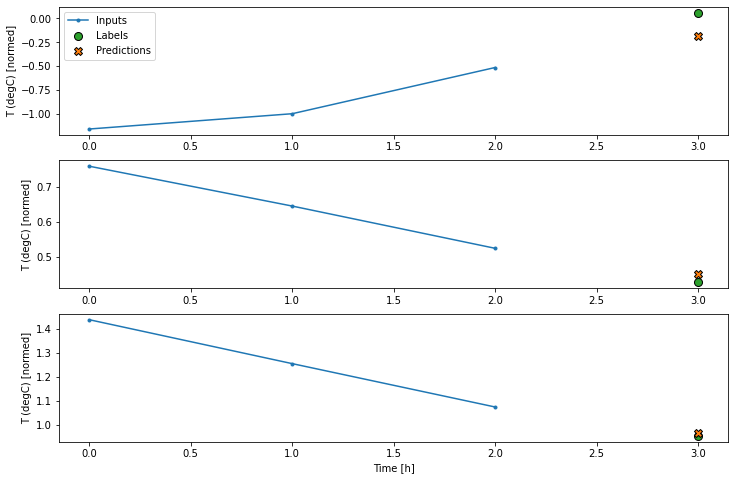

In [48]:
conv_window.plot(dense)

In [49]:
# CNN

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [50]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [51]:
history = compile_and_fit(conv_model, conv_window)

Epoch 1/100
1534/1534 [==============================] - 20s 8ms/step - loss: 0.0189 - mean_absolute_error: 0.0922 - val_loss: 0.0088 - val_mean_absolute_error: 0.0700
Epoch 2/100
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0082 - mean_absolute_error: 0.0660 - val_loss: 0.0071 - val_mean_absolute_error: 0.0600
Epoch 3/100
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0078 - mean_absolute_error: 0.0636 - val_loss: 0.0073 - val_mean_absolute_error: 0.0615
Epoch 4/100
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0074 - mean_absolute_error: 0.0615 - val_loss: 0.0066 - val_mean_absolute_error: 0.0575
Epoch 5/100
1534/1534 [==============================] - 12s 8ms/step - loss: 0.0071 - mean_absolute_error: 0.0602 - val_loss: 0.0065 - val_mean_absolute_error: 0.0567
Epoch 6/100
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0069 - mean_absolute_error: 0.0589 - val_loss: 0.0069 - val_mean_absolute_error:

In [52]:
print(conv_model.evaluate(conv_window.test, verbose=0))

[0.006712961941957474, 0.05843785032629967]


In [53]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [54]:
# Note that the output is shorter than the input. 
# To make training or plotting work, you need the labels, and prediction 
# to have the same length. 
# So build a WindowGenerator to produce wide windows with a few extra input 
# time steps so the label and prediction lengths match.

LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [55]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


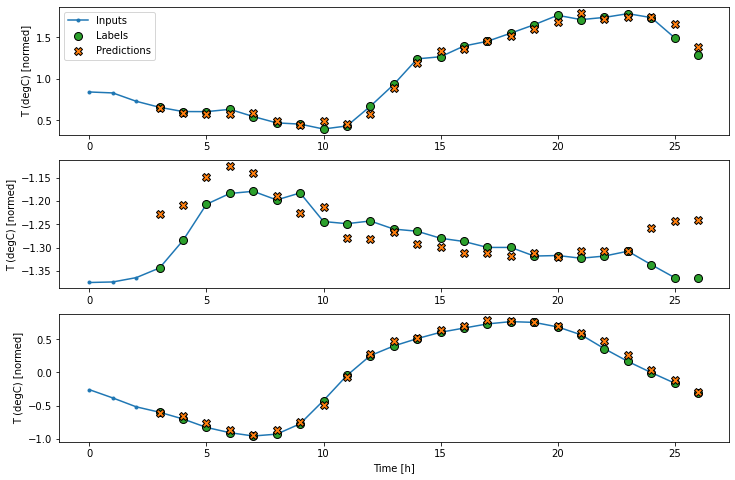

In [56]:
wide_conv_window.plot(conv_model)

In [57]:
# LSTM

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [58]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [59]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/100
1533/1533 [==============================] - 16s 9ms/step - loss: 0.0268 - mean_absolute_error: 0.0939 - val_loss: 0.0067 - val_mean_absolute_error: 0.0577
Epoch 2/100
1533/1533 [==============================] - 12s 8ms/step - loss: 0.0065 - mean_absolute_error: 0.0560 - val_loss: 0.0060 - val_mean_absolute_error: 0.0534
Epoch 3/100
1533/1533 [==============================] - 13s 8ms/step - loss: 0.0060 - mean_absolute_error: 0.0536 - val_loss: 0.0058 - val_mean_absolute_error: 0.0524
Epoch 4/100
1533/1533 [==============================] - 13s 8ms/step - loss: 0.0058 - mean_absolute_error: 0.0526 - val_loss: 0.0057 - val_mean_absolute_error: 0.0516
Epoch 5/100
1533/1533 [==============================] - 13s 9ms/step - loss: 0.0057 - mean_absolute_error: 0.0519 - val_loss: 0.0056 - val_mean_absolute_error: 0.0514
Epoch 6/100
1533/1533 [==============================] - 13s 8ms/step - loss: 0.0055 - mean_absolute_error: 0.0514 - val_loss: 0.0056 - val_mean_absolute_error:

In [60]:
print(lstm_model.evaluate(wide_window.test, verbose=0))

[0.0056278216652572155, 0.05228960141539574]


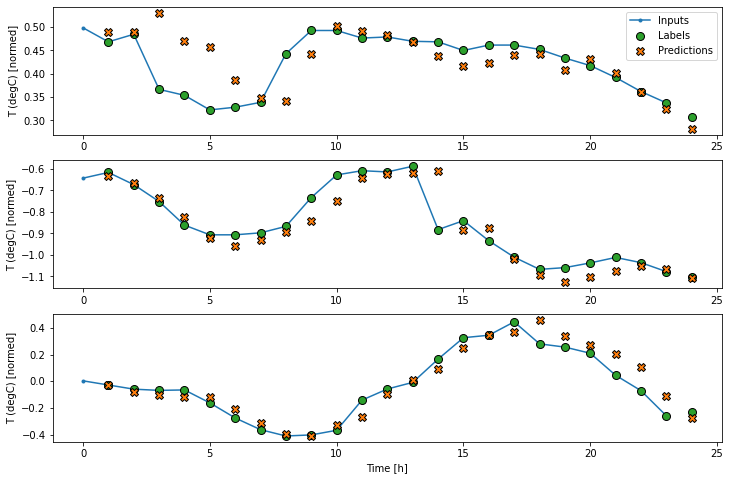

In [61]:
wide_window.plot(lstm_model)

In [62]:
# Multi-output models

# The models so far all predicted a single output feature, T (degC), for a single time step.
# All of these models can be converted to predict multiple features just by 
# changing the number of units in the output layer and adjusting the training 
# windows to include all features in the labels (example_labels)

single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


In [63]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [64]:
history = compile_and_fit(dense, single_step_window)

Epoch 1/100
1534/1534 [==============================] - 11s 7ms/step - loss: 0.1088 - mean_absolute_error: 0.1913 - val_loss: 0.0730 - val_mean_absolute_error: 0.1480
Epoch 2/100
1534/1534 [==============================] - 10s 7ms/step - loss: 0.0729 - mean_absolute_error: 0.1445 - val_loss: 0.0706 - val_mean_absolute_error: 0.1399
Epoch 3/100
1534/1534 [==============================] - 10s 7ms/step - loss: 0.0712 - mean_absolute_error: 0.1393 - val_loss: 0.0704 - val_mean_absolute_error: 0.1377
Epoch 4/100
1534/1534 [==============================] - 10s 7ms/step - loss: 0.0705 - mean_absolute_error: 0.1367 - val_loss: 0.0694 - val_mean_absolute_error: 0.1351
Epoch 5/100
1534/1534 [==============================] - 10s 7ms/step - loss: 0.0696 - mean_absolute_error: 0.1346 - val_loss: 0.0687 - val_mean_absolute_error: 0.1335
Epoch 6/100
1534/1534 [==============================] - 10s 7ms/step - loss: 0.0692 - mean_absolute_error: 0.1331 - val_loss: 0.0682 - val_mean_absolute_error:

In [65]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)


Epoch 1/100
1533/1533 [==============================] - 15s 8ms/step - loss: 0.1260 - mean_absolute_error: 0.2080 - val_loss: 0.0695 - val_mean_absolute_error: 0.1399
Epoch 2/100
1533/1533 [==============================] - 13s 8ms/step - loss: 0.0670 - mean_absolute_error: 0.1337 - val_loss: 0.0647 - val_mean_absolute_error: 0.1289
Epoch 3/100
1533/1533 [==============================] - 13s 8ms/step - loss: 0.0642 - mean_absolute_error: 0.1272 - val_loss: 0.0633 - val_mean_absolute_error: 0.1252
Epoch 4/100
1533/1533 [==============================] - 13s 9ms/step - loss: 0.0631 - mean_absolute_error: 0.1245 - val_loss: 0.0628 - val_mean_absolute_error: 0.1236
Epoch 5/100
1533/1533 [==============================] - 14s 9ms/step - loss: 0.0624 - mean_absolute_error: 0.1228 - val_loss: 0.0627 - val_mean_absolute_error: 0.1227
Epoch 6/100
1533/1533 [==============================] - 13s 8ms/step - loss: 0.0620 - mean_absolute_error: 0.1219 - val_loss: 0.0622 - val_mean_absolute_error:

In [66]:
# Multi-step models

# Both the single-output and multiple-output models in the previous sections made 
# single time step predictions, one hour into the future.

# In a multi-step prediction, the model needs to learn to predict a range of future values. 
# Thus, unlike a single step model, where only a single future point is predicted, 
# a multi-step model predicts a sequence of the future values.

# Two approaches
#   a) Single shot predictions where the entire time series is predicted at once
#   b) Autoregressive predictions where the model only makes single step predictions and 
#      its output is fed back as its input.

# Here, the models will learn to predict 24 hours into the future, given 24 hours of the past.

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

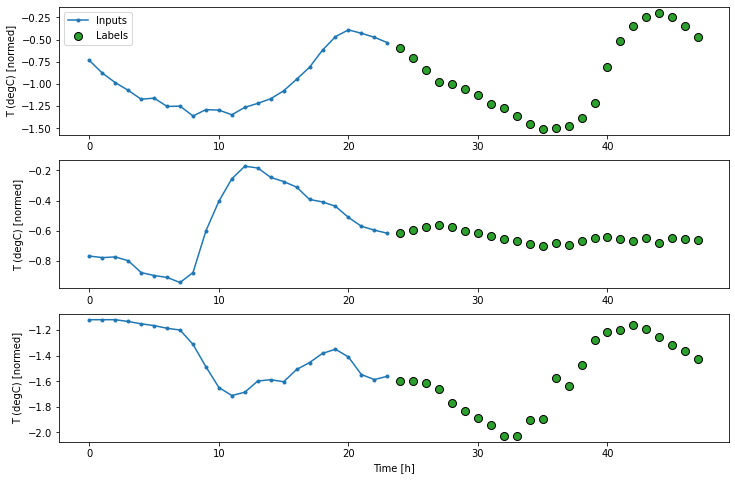

In [67]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [68]:
# Single-shot models

In [69]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(64, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

Epoch 1/100
1532/1532 [==============================] - 11s 7ms/step - loss: 0.2730 - mean_absolute_error: 0.3390 - val_loss: 0.2328 - val_mean_absolute_error: 0.3009
Epoch 2/100
1532/1532 [==============================] - 9s 6ms/step - loss: 0.2291 - mean_absolute_error: 0.2962 - val_loss: 0.2290 - val_mean_absolute_error: 0.2959
Epoch 3/100
1532/1532 [==============================] - 9s 6ms/step - loss: 0.2260 - mean_absolute_error: 0.2924 - val_loss: 0.2274 - val_mean_absolute_error: 0.2939
Epoch 4/100
1532/1532 [==============================] - 10s 6ms/step - loss: 0.2244 - mean_absolute_error: 0.2903 - val_loss: 0.2254 - val_mean_absolute_error: 0.2916
Epoch 5/100
1532/1532 [==============================] - 10s 6ms/step - loss: 0.2232 - mean_absolute_error: 0.2888 - val_loss: 0.2257 - val_mean_absolute_error: 0.2914
Epoch 6/100
1532/1532 [==============================] - 11s 7ms/step - loss: 0.2223 - mean_absolute_error: 0.2877 - val_loss: 0.2241 - val_mean_absolute_error: 0

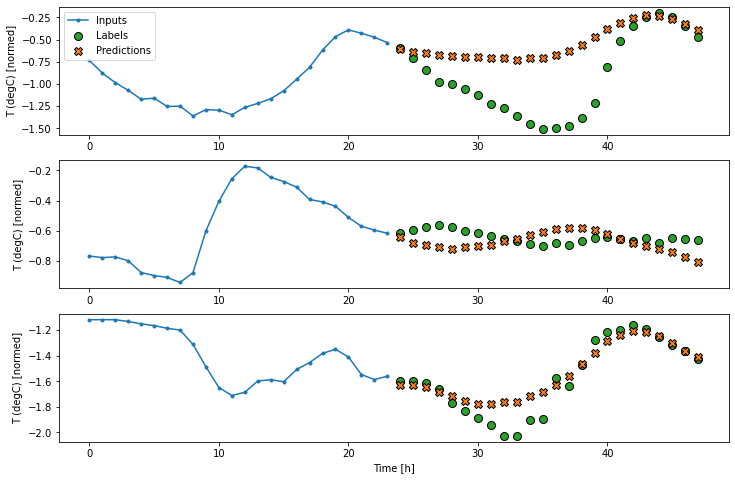

In [70]:
multi_window.plot(multi_dense_model)

In [73]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    # this code works since the kernel size is given as CONV_WIDTH which will take care of the input.
    # Assume we are feeding a three time step information to the network, say [0, 1, 2]
    # The kernel size is set to 3. It can convert the input data into a feature map
    # When we visualize the data as time x temperature (the feature that we considered in this problem),
    # The conv1d layers considers the input data as something that comes in each time step.
    # It means that, irrespective of the no. of features, the conv1d function takes input as a 1-D quantity (consider time as input) 
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)), 
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

Epoch 1/100
1532/1532 [==============================] - 15s 9ms/step - loss: 0.2426 - mean_absolute_error: 0.3105 - val_loss: 0.2255 - val_mean_absolute_error: 0.2929
Epoch 2/100
1532/1532 [==============================] - 13s 9ms/step - loss: 0.2201 - mean_absolute_error: 0.2877 - val_loss: 0.2212 - val_mean_absolute_error: 0.2863
Epoch 3/100
1532/1532 [==============================] - 14s 9ms/step - loss: 0.2162 - mean_absolute_error: 0.2836 - val_loss: 0.2207 - val_mean_absolute_error: 0.2872
Epoch 4/100
1532/1532 [==============================] - 13s 8ms/step - loss: 0.2131 - mean_absolute_error: 0.2803 - val_loss: 0.2183 - val_mean_absolute_error: 0.2854
Epoch 5/100
1532/1532 [==============================] - 15s 9ms/step - loss: 0.2109 - mean_absolute_error: 0.2785 - val_loss: 0.2166 - val_mean_absolute_error: 0.2821
Epoch 6/100
1532/1532 [==============================] - 13s 8ms/step - loss: 0.2092 - mean_absolute_error: 0.2769 - val_loss: 0.2171 - val_mean_absolute_error:

In [74]:
multi_conv_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 3, 19)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 256)            14848     
                                                                 
 dense_17 (Dense)            (None, 1, 456)            117192    
                                                                 
 reshape_3 (Reshape)         (None, 24, 19)            0         
                                                                 
Total params: 132,040
Trainable params: 132,040
Non-trainable params: 0
_________________________________________________________________


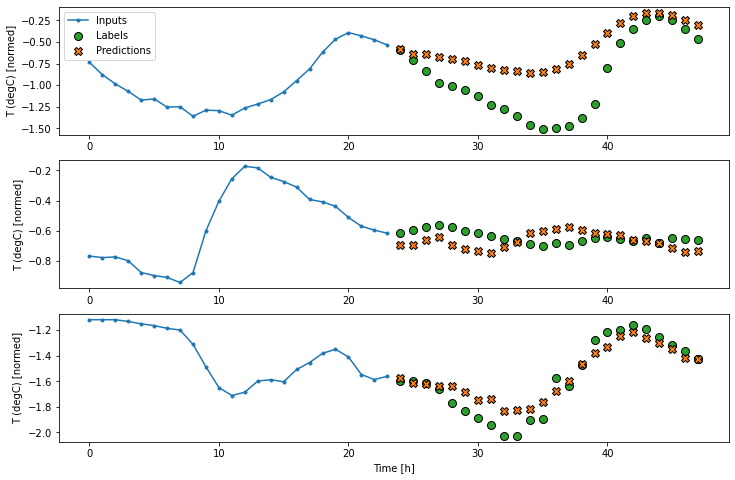

In [75]:
multi_window.plot(multi_conv_model)

In [76]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/100
1532/1532 [==============================] - 20s 11ms/step - loss: 0.2935 - mean_absolute_error: 0.3647 - val_loss: 0.2323 - val_mean_absolute_error: 0.3084
Epoch 2/100
1532/1532 [==============================] - 18s 12ms/step - loss: 0.2172 - mean_absolute_error: 0.2946 - val_loss: 0.2226 - val_mean_absolute_error: 0.2947
Epoch 3/100
1532/1532 [==============================] - 17s 11ms/step - loss: 0.2095 - mean_absolute_error: 0.2854 - val_loss: 0.2187 - val_mean_absolute_error: 0.2901
Epoch 4/100
1532/1532 [==============================] - 17s 11ms/step - loss: 0.2052 - mean_absolute_error: 0.2808 - val_loss: 0.2163 - val_mean_absolute_error: 0.2870
Epoch 5/100
1532/1532 [==============================] - 17s 11ms/step - loss: 0.2022 - mean_absolute_error: 0.2779 - val_loss: 0.2156 - val_mean_absolute_error: 0.2856
Epoch 6/100
1532/1532 [==============================] - 16s 10ms/step - loss: 0.2000 - mean_absolute_error: 0.2758 - val_loss: 0.2150 - val_mean_absolute_

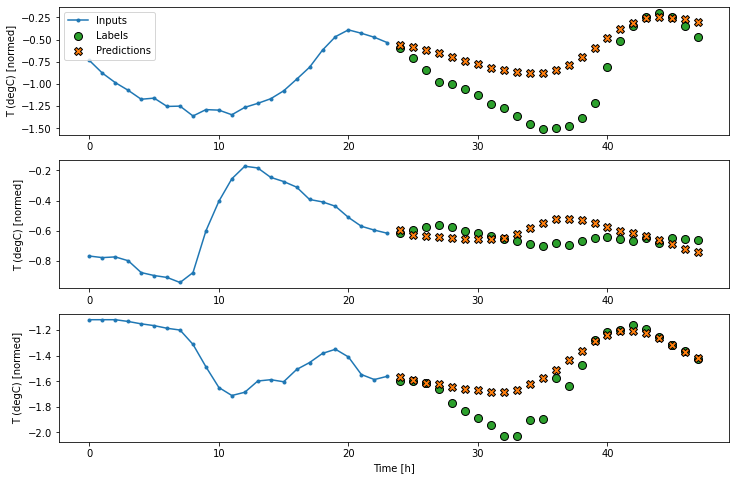

In [77]:
multi_window.plot(multi_lstm_model)

In [78]:
# Autoregressive model

In [79]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [80]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [81]:
# The first method this model needs is a warmup method to initialize its 
# internal state based on the inputs. Once trained, this state will capture 
# the relevant parts of the input history. This is equivalent to the 
# single-step LSTM model from earlier.

def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [82]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [83]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


In [84]:
history = compile_and_fit(feedback_model, multi_window)

Epoch 1/100
1532/1532 [==============================] - 184s 115ms/step - loss: 0.3120 - mean_absolute_error: 0.3865 - val_loss: 0.2494 - val_mean_absolute_error: 0.3311
Epoch 2/100
1532/1532 [==============================] - 176s 115ms/step - loss: 0.2347 - mean_absolute_error: 0.3178 - val_loss: 0.2339 - val_mean_absolute_error: 0.3120
Epoch 3/100
1532/1532 [==============================] - 92s 60ms/step - loss: 0.2239 - mean_absolute_error: 0.3052 - val_loss: 0.2328 - val_mean_absolute_error: 0.3112
Epoch 4/100
1532/1532 [==============================] - 92s 60ms/step - loss: 0.2180 - mean_absolute_error: 0.2987 - val_loss: 0.2326 - val_mean_absolute_error: 0.3123
Epoch 5/100
1532/1532 [==============================] - 91s 60ms/step - loss: 0.2138 - mean_absolute_error: 0.2943 - val_loss: 0.2284 - val_mean_absolute_error: 0.3060
Epoch 6/100
1532/1532 [==============================] - 91s 59ms/step - loss: 0.2105 - mean_absolute_error: 0.2908 - val_loss: 0.2240 - val_mean_absol

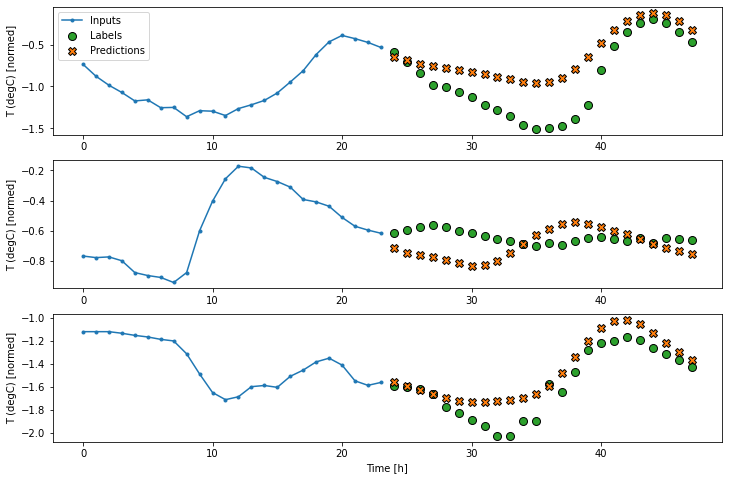

In [85]:
multi_window.plot(feedback_model)